In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        # print("curr v = ", v.data)
        if v not in nodes:
            # print("new, add to nodes")
            nodes.add(v)
            for child in v._prev:
                # print("curr child = ", child.data)
                edges.add((child, v))
                print(f"append (child, v) = ({child.data}, {v.data}) to edges")
                build(child)
            # print("exaust _prev for curr v.data ", v.data)
        # else:
        #     print("already visited, curr v = ", v.data)
                
    build(root)
    
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):  #_children means for internal use only 
        self.data = data
        #self._children = _children  
        # in argument: (self, other) is tuple -> set(self, other)  a+b treat a as self  
        # if Value(1) that is data=1, _children = empty tuple -> _prev = set(empty tupe) = set() empty set
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # 
        self.grad = 0.0   # have no effect on anything
        self._backward = lambda: None   
        # this is a function return None, diff function will be registered at operation, when e = a * b, e._op = '*', and e._backward\
    # will be the one inside
      
    
    def __repr__(self):
        # return f"Value(data={self.data}, _op = {self._op}, _grad = {self.grad}), _backward = {self._backward}\n"
        return f"Value(data={self.data}, )"


    def __add__(self, other):   # a + b -> call a.__add__(b)  
        out = Value(self.data + other.data, (self, other), '+')  # self.data is python recognized float
        
        # self.grad = 1.0 * out.grad
        # other.grad = 1.0 * out.grad
        #  put them inside a function, only _backward get called, do the calculation
        def _backward():
            print("add backward")
            print(f"register _backward: out = {out.data}, self = {self.data}, other = {other.data}")
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
            print(f"register grad: out.grad = {out.grad}, self.grad = {self.grad}, other.grad = {other.grad}")
        out._backward = _backward # assign function to a variale  (do not include argument , only function name)
        return out


    def __mul__(self, other):  # a * b in python -> call a.__mul__(b)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            print("multiply backward")
            print(f"register _backward: out = {out.data}, self = {self.data}, other = {other.data}")
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
            print(f"register grad: out.grad = {out.grad}, self.grad = {self.grad}, other.grad = {other.grad}")
        out._backward = _backward
        return out

    
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)  # farest point a or b has no prev, added first, after all prev a and b added, e added, then c, then d
        
        build_topo(self)
        print("topo list:")
        print(topo)

        self.grad = 1.0
        for node in reversed(topo): # return a new list
            print(f"d{self.data}/d{node.data}")
            print(node)
            node._backward()
            
        



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
# d.backward()  # call this def backward(self):
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'  # L = (a * b + c) * f
L

d.backward()
L.backward()

topo list:
[Value(data=2.0, ), Value(data=-3.0, ), Value(data=-6.0, ), Value(data=10.0, ), Value(data=4.0, )]
d4.0/d4.0
Value(data=4.0, )
add backward
register _backward: out = 4.0, self = -6.0, other = 10.0
register grad: out.grad = 1.0, self.grad = 1.0, other.grad = 1.0
d4.0/d10.0
Value(data=10.0, )
d4.0/d-6.0
Value(data=-6.0, )
multiply backward
register _backward: out = -6.0, self = 2.0, other = -3.0
register grad: out.grad = 1.0, self.grad = -3.0, other.grad = 2.0
d4.0/d-3.0
Value(data=-3.0, )
d4.0/d2.0
Value(data=2.0, )
topo list:
[Value(data=2.0, ), Value(data=-3.0, ), Value(data=-6.0, ), Value(data=10.0, ), Value(data=4.0, ), Value(data=-2.0, ), Value(data=-8.0, )]
d-8.0/d-8.0
Value(data=-8.0, )
multiply backward
register _backward: out = -8.0, self = 4.0, other = -2.0
register grad: out.grad = 1.0, self.grad = -2.0, other.grad = 4.0
d-8.0/d-2.0
Value(data=-2.0, )
d-8.0/d4.0
Value(data=4.0, )
add backward
register _backward: out = 4.0, self = -6.0, other = 10.0
register grad: o

append (child, v) = (4.0, -8.0) to edges
append (child, v) = (-6.0, 4.0) to edges
append (child, v) = (2.0, -6.0) to edges
append (child, v) = (-3.0, -6.0) to edges
append (child, v) = (10.0, 4.0) to edges
append (child, v) = (-2.0, -8.0) to edges


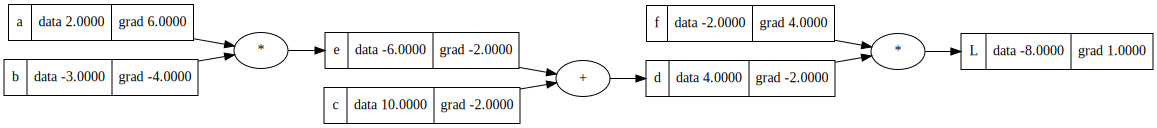

In [4]:
draw_dot(L)

In [5]:
# Follow definition of derivative (y = f(x), as h->0,  derivative of y @ x0 (f(x0+h) - f(x0))/h
def lol():
  
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
  
    print((L2 - L1)/h)
  
lol()
# L = (a *b + c) * f = (2 * -3 + 10) * -2
#dL/df =  (a*b+c) = 4
#dL/dd = f = -2
#dL/dc = dL/dd * dd/dc = f * 1 = -2
#dL/de = dL/dd * dd/de = f * 1 = -2
#dL/da = dL/de * de/da = dL/dd * dd/de * de/da = -2 * -3 = 6

6.000000000000227


In [6]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)  # farest point a or b has no prev, added first, after all prev a and b added, e added, then c, then d

build_topo(d)
print(topo)
topo.reverse()
print(topo)

[Value(data=2.0, ), Value(data=-3.0, ), Value(data=-6.0, ), Value(data=10.0, ), Value(data=4.0, )]
[Value(data=4.0, ), Value(data=10.0, ), Value(data=-6.0, ), Value(data=-3.0, ), Value(data=2.0, )]


topo list:
[Value(data=3.0, grad=0.0), Value(data=-2.0, grad=0.0), Value(data=-6.0, grad=0.0), Value(data=1.0, grad=0.0), Value(data=-6.0, grad=0.0)]
d-6.0/d-6.0
Value(data=-6.0, grad=1.0)
multiply backward
register _backward: out = -6.0, self = -6.0, other = 1.0
register grad: out.grad = 1.0, self.grad = 1.0, other.grad = -6.0
d-6.0/d1.0
Value(data=1.0, grad=-6.0)
add backward
register _backward: out = 1.0, self = -2.0, other = 3.0
register grad: out.grad = -6.0, self.grad = -6.0, other.grad = -6.0
d-6.0/d-6.0
Value(data=-6.0, grad=1.0)
multiply backward
register _backward: out = -6.0, self = -2.0, other = 3.0
register grad: out.grad = 1.0, self.grad = -3.0, other.grad = -8.0
d-6.0/d-2.0
Value(data=-2.0, grad=-3.0)
d-6.0/d3.0
Value(data=3.0, grad=-8.0)
append (child, v) = (-6.0, -6.0) to edges
append (child, v) = (3.0, -6.0) to edges
append (child, v) = (-2.0, -6.0) to edges
append (child, v) = (1.0, -6.0) to edges
append (child, v) = (3.0, 1.0) to edges
append (child, v) = (-2.0, 1.0

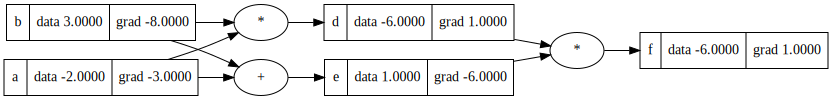

In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):  #_children means for internal use only 
        self.data = data
        #self._children = _children  
        # in argument: (self, other) is tuple -> set(self, other)  a+b treat a as self  
        # if Value(1) that is data=1, _children = empty tuple -> _prev = set(empty tupe) = set() empty set
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # 
        self.grad = 0.0   # have no effect on anything
        self._backward = lambda: None   
        # this is a function return None, diff function will be registered at operation, when e = a * b, e._op = '*', and e._backward\
    # will be the one inside
      
    
    def __repr__(self):
        # return f"Value(data={self.data}, _op = {self._op}, _grad = {self.grad}), _backward = {self._backward}\n"
        return f"Value(data={self.data}, grad={self.grad})"


    def __add__(self, other):   # a + b -> call a.__add__(b)  
        out = Value(self.data + other.data, (self, other), '+')  # self.data is python recognized float
        
        # self.grad = 1.0 * out.grad
        # other.grad = 1.0 * out.grad
        #  put them inside a function, only _backward get called, do the calculation
        def _backward():
            print("add backward")
            print(f"register _backward: out = {out.data}, self = {self.data}, other = {other.data}")
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            print(f"register grad: out.grad = {out.grad}, self.grad = {self.grad}, other.grad = {other.grad}")
        out._backward = _backward # assign function to a variale  (do not include argument , only function name)
        return out


    def __mul__(self, other):  # a * b in python -> call a.__mul__(b)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            print("multiply backward")
            print(f"register _backward: out = {out.data}, self = {self.data}, other = {other.data}")
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            print(f"register grad: out.grad = {out.grad}, self.grad = {self.grad}, other.grad = {other.grad}")
        out._backward = _backward
        return out

    
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)  # farest point a or b has no prev, added first, after all prev a and b added, e added, then c, then d
        
        build_topo(self)
        print("topo list:")
        print(topo)

        self.grad = 1.0
        for node in reversed(topo): # return a new list
            print(f"d{self.data}/d{node.data}")
            print(node)
            node._backward()



a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'  
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f' # f = d * e = (a * b) * (a + b) = a * b * a + a * b *b 
# d = -6, e = 1
#df/dd = 1, df/de = -6
#df/da = 2*a*b + b*b = 2*-2*3 + 3*3 = -3 
#df/db = a*a + a*2b = 4 + -2*2*3 = -8 

# use + for grad will override the track of a.grad from d when calculate a.grad from e
# use += for grad if the same value used mulyiple times along the calculation
f.backward()

draw_dot(f)

append (child, v) = (0.8813735870195432, 0.7071067811865477) to edges
append (child, v) = (6.881373587019543, 0.8813735870195432) to edges
append (child, v) = (-6.0, 0.8813735870195432) to edges
append (child, v) = (-6.0, -6.0) to edges
append (child, v) = (2.0, -6.0) to edges
append (child, v) = (-3.0, -6.0) to edges
append (child, v) = (0.0, -6.0) to edges
append (child, v) = (1.0, 0.0) to edges
append (child, v) = (0.0, 0.0) to edges


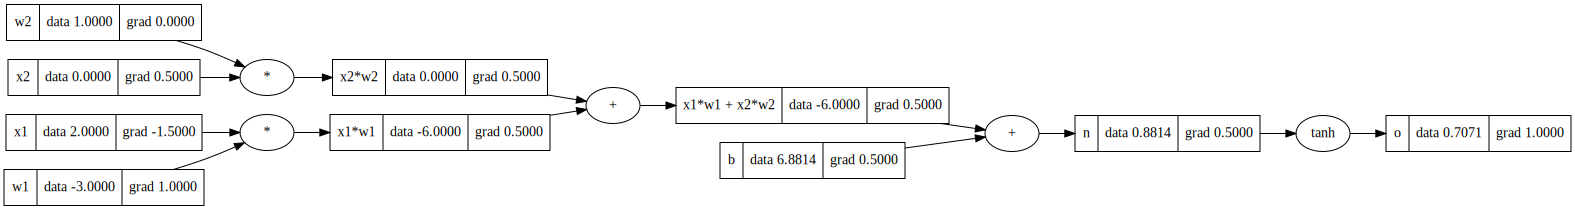

In [99]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):  #_children means for internal use only 
        self.data = data
        #self._children = _children  
        # in argument: (self, other) is tuple -> set(self, other)  a+b treat a as self  
        # if Value(1) that is data=1, _children = empty tuple -> _prev = set(empty tupe) = set() empty set
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # 
        self.grad = 0.0   # have no effect on anything
        self._backward = lambda: None   
        # this is a function return None, diff function will be registered at operation, when e = a * b, e._op = '*', and e._backward\
    # will be the one inside
      
    
    def __repr__(self):
        # return f"Value(data={self.data}, _op = {self._op}, _grad = {self.grad}), _backward = {self._backward}\n"
        return f"Value(data={self.data}, grad={self.grad})"


    def __add__(self, other):   # a + b -> call a.__add__(b)
        
        other = other if isinstance(other, Value) else Value(other) 
        
        out = Value(self.data + other.data, (self, other), '+')  # self.data is python recognized float
        
        # self.grad = 1.0 * out.grad
        # other.grad = 1.0 * out.grad
        #  put them inside a function, only _backward get called, do the calculation
        def _backward():
            # print("add backward")
            # print(f"register _backward: out = {out.data}, self = {self.data}, other = {other.data}")
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            # print(f"register grad: out.grad = {out.grad}, self.grad = {self.grad}, other.grad = {other.grad}")
        out._backward = _backward # assign function to a variale  (do not include argument , only function name)
        return out
        

    def __mul__(self, other):  # a * b in python -> call a.__mul__(b)
        other = other if isinstance(other, Value) else Value(other) 
        
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            # print("multiply backward")
            # print(f"register _backward: out = {out.data}, self = {self.data}, other = {other.data}")
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            # print(f"register grad: out.grad = {out.grad}, self.grad = {self.grad}, other.grad = {other.grad}")
        out._backward = _backward
        return out
        
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        # out = Value(self.data ** other, (self, other), _op='**')
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * self.data ** (other-1.0) * out.grad    
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    
    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other
        
    def __truediv__(self, other): # self / other
        return self * other**-1

    
    def __sub__(self, other): # self - other
        return self + (-other)
        
    # functions above analog to pre-built funcs in python for int/float
    
    def exp(self): 
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    
    def tanh(self): 
        # out = Value(math.tanh(self.data), (self,), 'tanh')   #alternative
        x = self.data
        y = (math.exp(x) - math.exp(-x))/(math.exp(x) + math.exp(-x))
        out = Value(y, (self,), 'tanh')
        
        def _backward():  #Value.tanh.localFunction  self, out is available
            self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward
        return out
        
    
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)  # farest point a or b has no prev, added first, after all prev a and b added, e added, then c, then d
        
        build_topo(self)
        # print("topo list:")
        # print(topo)

        self.grad = 1.0
        for node in reversed(topo): # return a new list
            # print(f"d{self.data}/d{node.data}")
            # print(node)
            node._backward()



# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

In [9]:
math.tanh(0.8814)

0.7071199874301226

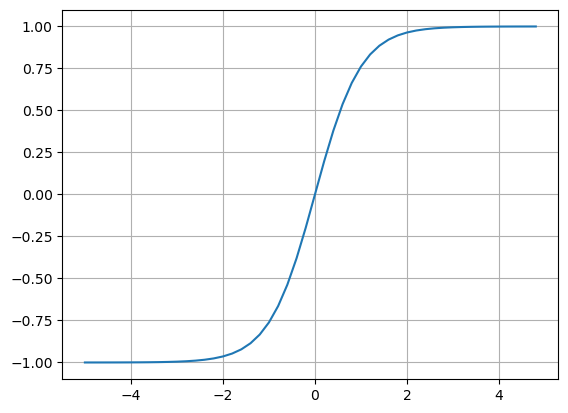

In [10]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

topo list:
[Value(data=-1, grad=0.0), Value(data=2.0, grad=0.0), Value(data=-3.0, grad=0.0), Value(data=-6.0, grad=0.0), Value(data=1.0, grad=0.0), Value(data=0.0, grad=0.0), Value(data=0.0, grad=0.0), Value(data=-6.0, grad=0.0), Value(data=6.881373587019543, grad=0.0), Value(data=0.8813735870195432, grad=0.0), Value(data=2, grad=0.0), Value(data=1.7627471740390863, grad=0.0), Value(data=5.828427124746192, grad=0.0), Value(data=4.828427124746192, grad=0.0), Value(data=1, grad=0.0), Value(data=6.828427124746192, grad=0.0), Value(data=0.1464466094067262, grad=0.0), Value(data=0.7071067811865477, grad=0.0)]
d0.7071067811865477/d0.7071067811865477
Value(data=0.7071067811865477, grad=1.0)
multiply backward
register _backward: out = 0.7071067811865477, self = 4.828427124746192, other = 0.1464466094067262
register grad: out.grad = 1.0, self.grad = 0.1464466094067262, other.grad = 4.828427124746192
d0.7071067811865477/d0.1464466094067262
Value(data=0.1464466094067262, grad=4.828427124746192)
d

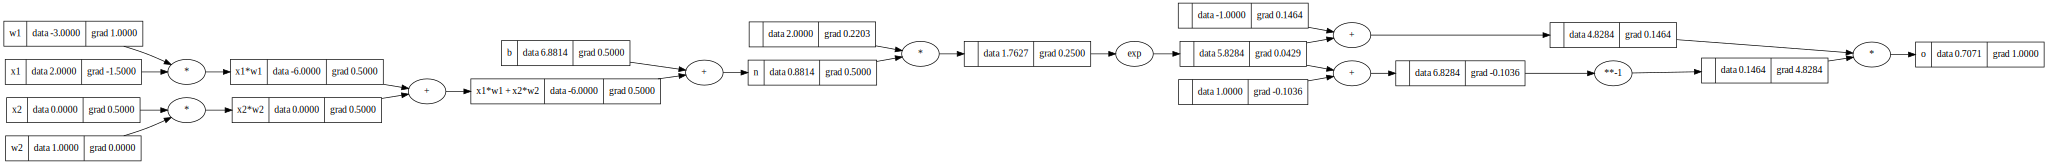

In [11]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [12]:
help(2.0*2)

Help on float object:

class float(object)
 |  float(x=0, /)
 |  
 |  Convert a string or number to a floating point number, if possible.
 |  
 |  Methods defined here:
 |  
 |  __abs__(self, /)
 |      abs(self)
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __bool__(self, /)
 |      True if self else False
 |  
 |  __ceil__(self, /)
 |      Return the ceiling as an Integral.
 |  
 |  __divmod__(self, value, /)
 |      Return divmod(self, value).
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __float__(self, /)
 |      float(self)
 |  
 |  __floor__(self, /)
 |      Return the floor as an Integral.
 |  
 |  __floordiv__(self, value, /)
 |      Return self//value.
 |  
 |  __format__(self, format_spec, /)
 |      Formats the float according to format_spec.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getnewargs__(self, /)
 |  
 |  __gt__(sel

In [13]:
import torch

In [14]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [44]:
import random

In [101]:

class Neuron:
  
  def __init__(self, nin): # nint: #dims for a single input x
    print(f"initialize neuron for nin={nin}")
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
    
    print("self.w = ", self.w)
    print("self.b = ", self.b)

    
  def __call__(self, x): # x should represent data [Value(1), Value(2), Value(3)] 
      # __call__ allows an instance is used as a function: 
       # __init__  :  x = Foo(1, 2, 3)
      # __call__ :  x(1,2,3)
      # With __call__ you can redefine the same object as if it were new.
    # w * x + b  (single one Value)

    # out = sum([wi * xi for (wi, xi) in list(zip(self.w, x))]) + b  : wrong
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
      
    return out
      
  
  def parameters(self):
    print("neuron parameters: ")
    return self.w + [self.b]


class Layer:
  
  def __init__(self, nin, nout):
    print(f"initilizing layer with nin = {nin}, nout = {nout} neurons.")
    self.neurons = [Neuron(nin) for _ in range(nout)]  # init struct of neuron in neurons
    print("self.neurons = ", self.neurons)
    
  
  def __call__(self, x): 
    # out = Neuron(x) ;: wrong
    # out = [n.tanh() for n in out] if len(out) > 1 else out[0].tanh(): wrong
    print(f"call layer with real data x = {x}")
    outs = [n(x) for n in self.neurons] # n here is neuron initilized, n(x) use neuron. __call__(x_
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    print("layer params: ")
    return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:
  
  def __init__(self, nin, nouts):
    print(f"initializing MLP with nin={nin}, nouts = {nouts}")
    sz = [nin] + nouts  # for nin = 3, nouts=[4,4,1]  layer dims [3,4], [4,4], [4,1]
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]# init  Layers = [layer(3, 4), layer(4,4), layer(4,1)]
    print("self.layers: ", self.layers)
  
  def __call__(self, x):
    for layer in self.layers:  # initialize each layer's struct
        x = layer(x) #__call__
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [102]:
# data set with 1 example
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

print("parameters: ", n.parameters())
n(x)

initializing MLP with nin=3, nouts = [4, 4, 1]
initilizing layer with nin = 3, nout = 4 neurons.
initialize neuron for nin=3
self.w =  [Value(data=0.09031862272788893, grad=0.0), Value(data=-0.6685374806925202, grad=0.0), Value(data=-0.4833121129427247, grad=0.0)]
self.b =  Value(data=-0.08524125916937364, grad=0.0)
initialize neuron for nin=3
self.w =  [Value(data=0.8526317211489867, grad=0.0), Value(data=0.39043576047583906, grad=0.0), Value(data=-0.617032850819581, grad=0.0)]
self.b =  Value(data=0.5291373855242909, grad=0.0)
initialize neuron for nin=3
self.w =  [Value(data=0.006948671323777411, grad=0.0), Value(data=0.10468448850951506, grad=0.0), Value(data=0.9757029263660202, grad=0.0)]
self.b =  Value(data=0.44560798551726566, grad=0.0)
initialize neuron for nin=3
self.w =  [Value(data=0.6481269371582743, grad=0.0), Value(data=0.2247209678048696, grad=0.0), Value(data=0.7395904941870854, grad=0.0)]
self.b =  Value(data=0.5180998822216656, grad=0.0)
self.neurons =  [<__main__.Ne

Value(data=-0.6845703687848746, grad=0.0)

In [103]:
# data set with 4 examples

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [106]:
for k in range(20):  # training is a loop of steps
  
  # forward pass
    # MLP STRUCTURE IS THE SAME n = MLP(3, [4, 4, 1]), this time use n(x)  __call__ to take on new x values
  ypred = [n(x) for x in xs]  
  print("ypred: ", ypred)
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  #loss is a Value object now, since all weights initiliazed as Value
    # loss is a bottom down curve, the further yout from ygt, the bigger the loss, so when grad<0, need to increase yout.
    
  # draw_dot(loss)
  # # now calculate grad of all parameters using loss.backward
    # for loops after the first one, we need to re-calculate grads with updated parameters' value, do not cumulate grad
  for p in n.parameters():  
    p.grad = 0.0
  
  loss.backward()  # 1st one is dloss/dloss = 1.0 no need to set up manually, 

  for p in n.parameters():
    p.data += -0.1 * p.grad  # keep p.data cumulated thru steps
      # loss is a bottom down curve, the further yout from ygt, the bigger the loss, so when grad<0, need to increase yout.

  print(k, loss.data)
    
    
ypred    

call layer with real data x = [2.0, 3.0, -1.0]
call layer with real data x = [Value(data=-0.9770241470727148, grad=0.0), Value(data=0.9996859331554743, grad=0.0), Value(data=0.031124522082104505, grad=0.0), Value(data=0.9898241793052853, grad=0.0)]
call layer with real data x = [Value(data=-0.824619351195134, grad=0.0), Value(data=-0.9581348926149437, grad=0.0), Value(data=0.6333629561260372, grad=0.0), Value(data=-0.9687911741449788, grad=0.0)]
call layer with real data x = [3.0, -1.0, 0.5]
call layer with real data x = [Value(data=0.9901014573889391, grad=0.0), Value(data=0.9877776096733776, grad=0.0), Value(data=0.5838746861955485, grad=0.0), Value(data=0.9932626704163914, grad=0.0)]
call layer with real data x = [Value(data=0.9225105043893658, grad=0.0), Value(data=-0.8456121489440843, grad=0.0), Value(data=-0.7361935490203211, grad=0.0), Value(data=-0.1631039327003211, grad=0.0)]
call layer with real data x = [0.5, 1.0, 1.0]
call layer with real data x = [Value(data=0.467650500137

[Value(data=0.9572654055663654, grad=-0.08546918886726917),
 Value(data=-0.9646295454692377, grad=0.07074090906152453),
 Value(data=-0.9396377113559196, grad=0.12072457728816088),
 Value(data=0.9433659365005984, grad=-0.11326812699880318)]